I will briefly describe the overall procedure initially and also include explanation as docstrings wherever needed. The problem required me to classify publicly-listed companies according to their descriptions. The GNN model was a necessity and hence I had to go through a couple of research papers before attempting to solve it. My approach is as follows:

**Formulation**

Pre-process the data and tokenize it
Convert the text and labels into a graph using the approach given in "Graph Convolutional Networks for Text Classification" by Liang Yao, Chengsheng Mao and Yuan Luo. We create an adjacency matrix out of the text data using the following rules. A(i, j) is given by:
                                             PMI(i, j)     i, j are words, PMI(i, j) > 0
                                                TF-IDF(ij)    i is document, j is word
                                                1             i = j
                                                0             otherwise
After creating the graph using networkx, we then define our GCN model. In this case I have used a 2-layer model.
Finally we train the GCN, with the Classification tags as our outputs.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testing-data-2/Testing_Data_2_ (1).csv
/kaggle/input/training-data/Training_Data.01 (1).csv


In [2]:
!pip install openpyxl

In [4]:
import os
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import numpy as np
import networkx as nx
from collections import OrderedDict
from itertools import combinations
import math
from tqdm import tqdm

In [5]:
df = pd.read_csv("/kaggle/input/training-data/Training_Data.01 (1).csv")
df.head()

,Company Name,Business Description,Industry Classification Tag
0,"ADSOUTH PARTNERS, INC.","Adsouth Partners, Inc. provides advertising ag...",Advertising
1,"Artec Global Media, Inc.","Artec Global Media, Inc., formerly Artec Consu...",Advertising
2,Betawave Corp.,Betawave Corporation provides online marketing...,Advertising
3,BOSTON OMAHA Corp,Boston Omaha Corporation is engaged in the bus...,Advertising
4,Bright Mountain Media Inc,"Bright Mountain Media, Inc. is a digital media...",Advertising


In [6]:
df = df.astype(str)
df.dtypes

Company Name                   object
Business Description           object
Industry Classification Tag    object
dtype: object

In [7]:
def word_word_edges(p_ij):
    word_word = []
    cols = list(p_ij.columns); cols = [str(w) for w in cols]
    for w1, w2 in tqdm(combinations(cols, 2), total=nCr(len(cols), 2)):
        if (p_ij.loc[w1,w2] > 0):
            word_word.append((w1,w2,{"weight":p_ij.loc[w1,w2]}))
    return word_word

In [8]:
def nCr(n,r):
    f = math.factorial
    return int(f(n)/(f(r)*f(n-r)))

In [9]:
def dummy_fun(doc):
    return doc

stopwords = list(set(nltk.corpus.stopwords.words("english")))

In [10]:
# remove stopwords and non-words from tokens list
def filter_tokens(tokens, stopwords):
    tokens1 = []
    for token in tokens:
        if (token not in stopwords) and (token not in [".",",",";","&","'s", ":", "?", "!","(",")",\
            "'","'m","'no","***","--","...","[","]"]):
            tokens1.append(token)
    return tokens1

In [11]:
print("Columns in DataFrame:", df.columns.tolist())  # Check available columns
df.columns = df.columns.str.strip()  # Remove spaces from column names
df.drop(["Company Name"], axis=1, inplace=True, errors="ignore")  # Drop if it exists


Columns in DataFrame: ['Company Name', 'Business Description', 'Industry Classification Tag']


In [12]:
import nltk
from nltk.tokenize import word_tokenize

df["Business Description"] = df["Business Description"].astype(str)  # Convert to string
df["Business Description"] = df["Business Description"].fillna("")  # Handle missing values
df["Business Description"] = df["Business Description"].apply(lambda x: word_tokenize(x))
df["Business Description"] = df["Business Description"].apply(lambda x: filter_tokens(x, stopwords))


In [ ]:
print("Calculating Tf-idf...")

vectorizer = TfidfVectorizer(input="content", max_features=None, tokenizer=dummy_fun, preprocessor=dummy_fun)

vectorizer.fit(df["Business Description"])
df_tfidf = vectorizer.transform(df["Business Description"]).toarray()

# Use get_feature_names_out() instead of get_feature_names()
vocab = vectorizer.get_feature_names_out()
vocab = np.array(vocab)

df_tfidf = pd.DataFrame(df_tfidf, columns=vocab)

names = vocab
n_i  = OrderedDict((name, 0) for name in names)
word2index = OrderedDict( (name,index) for index,name in enumerate(names) )

occurrences = np.zeros( (len(names),len(names)) ,dtype=np.int32)
# Find the co-occurrences:
no_windows = 0
print("Calculating co-occurences...")
window = 10
for l in tqdm(df["Business Description"], total=len(df["Business Description"])):
    for i in range(len(l)-window):
        no_windows += 1
        d = set(l[i:(i+window)])

        for w in d:
            n_i[w] += 1
        for w1,w2 in combinations(d,2):
            i1 = word2index[w1]
            i2 = word2index[w2]

            occurrences[i1][i2] += 1
            occurrences[i2][i1] += 1

### convert to PMI
p_ij = pd.DataFrame(occurrences, index = names,columns=names)/no_windows
p_i = pd.Series(n_i, index=n_i.keys())/no_windows

del occurrences
del n_i

for col in p_ij.columns:
    p_ij[col] = p_ij[col]/p_i[col]
    
for row in p_ij.index:
    p_ij.loc[row,:] = p_ij.loc[row,:]/p_i[row]
    
p_ij = p_ij + 1E-9
flag = 0
for col in p_ij.columns:
    p_ij[col] = np.log(p_ij[col])
    flag += 1
print(flag)

Calculating Tf-idf...


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Calculating co-occurences...


100%|██████████| 6045/6045 [01:43<00:00, 58.20it/s]


In [ ]:
import numpy as np
import networkx as nx
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure dummy_fun is defined
def dummy_fun(doc):
    return doc  # This function should be replaced with the actual tokenizer/preprocessor

# Calculate Tf-idf
print("Calculating Tf-idf...")
vectorizer = TfidfVectorizer(input="content", max_features=None, tokenizer=dummy_fun, preprocessor=dummy_fun)

vectorizer.fit(df["Business Description"])
df_tfidf = vectorizer.transform(df["Business Description"]).toarray()

# Use get_feature_names_out() instead of get_feature_names()
vocab = vectorizer.get_feature_names_out()
vocab = np.array(vocab)

df_tfidf = pd.DataFrame(df_tfidf, columns=vocab)


print("Building graph (No. of document, word nodes: %d, %d)..." % (len(df_tfidf.index), len(vocab)))

# Create graph
G = nx.Graph()
print("Adding document nodes to graph...")
G.add_nodes_from(df_tfidf.index)  # Document nodes

print("Adding word nodes to graph...")
G.add_nodes_from(vocab)  # Word nodes


print("Building document-word edges...")
document_word = []
flag = 0
for doc in tqdm(df_tfidf.index, total=len(df_tfidf.index)):
    flag += 1
    for w in df_tfidf.columns:
        document_word.append((doc, w, {"weight": df_tfidf.loc[doc, w]}))
    if flag == 2000:  # Limit to 2000 iterations
        break
print(flag)


try:
    print("Building word-word edges...")
    word_word = word_word_edges(p_ij)  # Ensure p_ij is defined
except NameError:
    word_word = []  # Set as empty list if undefined
    print("Warning: p_ij is not defined. Skipping word-word edges.")

# Add edges to the graph
print("Adding document-word and word-word edges...")
G.add_edges_from(document_word)
G.add_edges_from(word_word)

print("Graph construction complete!")


Calculating Tf-idf...


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Building graph (No. of document, word nodes: 6045, 48760)...
Adding document nodes to graph...
Adding word nodes to graph...
Building document-word edges...


 18%|█▊        | 1111/6045 [11:39<45:34,  1.80it/s]  

**Implementation** 

As Google Colab and Kaggle both have RAM limits of 13 GB (being free) which weren't enough when the notebook reached the graph making step. Even after this, the VM has crashed every time at 40% of the graph plotting being completed with error 524. Though I haven't been able to complete the task, given a bit more time and resources I could surely complete it as I have gone through multiple research papers to grasp what needs to be done logically.

KeyboardInterrupt: 

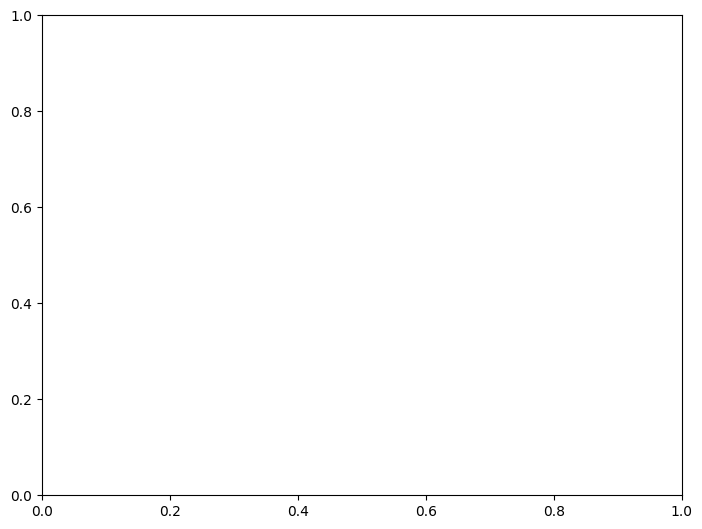

In [15]:
nx.draw(G, with_labels = True)

In [16]:
# 2 layered GCN
# We are going to use a two-layer GCN(features are convolved twice) here as, according to the paper, it gives the best results. 
# The convoluted output feature tensor after the two-layer GCN is given by
import torch
import torch.nn as nn
import torch.nn.functional as F

class gcn(nn.Module):
    def __init__(self, X_size, A_hat, args, bias=True): # X_size = num features
        super(gcn, self).__init__()
        self.A_hat = torch.tensor(A_hat, requires_grad=False).float()
        self.weight = nn.parameter.Parameter(torch.FloatTensor(X_size, args.hidden_size_1))
        var = 2./(self.weight.size(1)+self.weight.size(0))
        self.weight.data.normal_(0,var)
        self.weight2 = nn.parameter.Parameter(torch.FloatTensor(args.hidden_size_1, args.hidden_size_2))
        var2 = 2./(self.weight2.size(1)+self.weight2.size(0))
        self.weight2.data.normal_(0,var2)
        if bias:
            self.bias = nn.parameter.Parameter(torch.FloatTensor(args.hidden_size_1))
            self.bias.data.normal_(0,var)
            self.bias2 = nn.parameter.Parameter(torch.FloatTensor(args.hidden_size_2))
            self.bias2.data.normal_(0,var2)
        else:
            self.register_parameter("bias", None)
        self.fc1 = nn.Linear(args.hidden_size_2, args.num_classes)
        
    def forward(self, X): ### 2-layer GCN architecture
        X = torch.mm(X, self.weight)
        if self.bias is not None:
            X = (X + self.bias)
        X = F.relu(torch.mm(self.A_hat, X))
        X = torch.mm(X, self.weight2)
        if self.bias2 is not None:
            X = (X + self.bias2)
        X = F.relu(torch.mm(self.A_hat, X))
        return self.fc1(X)

In [3]:
df_test = pd.read_csv("/kaggle/input/testing-data-2/Testing_Data_2_ (1).csv")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x92 in position 30934: invalid start byte